In [1]:
# 1. IMPORTAÇÕES E CONFIGURAÇÕES INICIAIS
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [4]:
# Conversão de 'TotalCharges' para numérico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [5]:
# Remover valores nulos
df.dropna(inplace=True)

In [6]:
# Converter variável alvo para binária
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [7]:
# =============================
# 3. ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)
# =============================
# Visão geral
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 
 17  

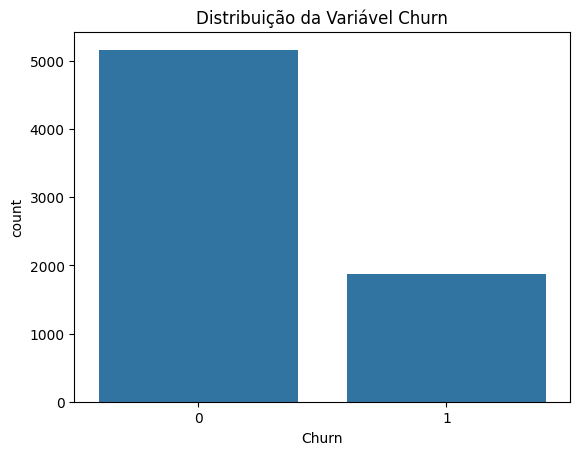

Taxa de Churn: 26.58%


In [8]:
# Distribuição da variável alvo
sns.countplot(x='Churn', data=df)
plt.title('Distribuição da Variável Churn')
plt.show()

print(f"Taxa de Churn: {df['Churn'].mean():.2%}")

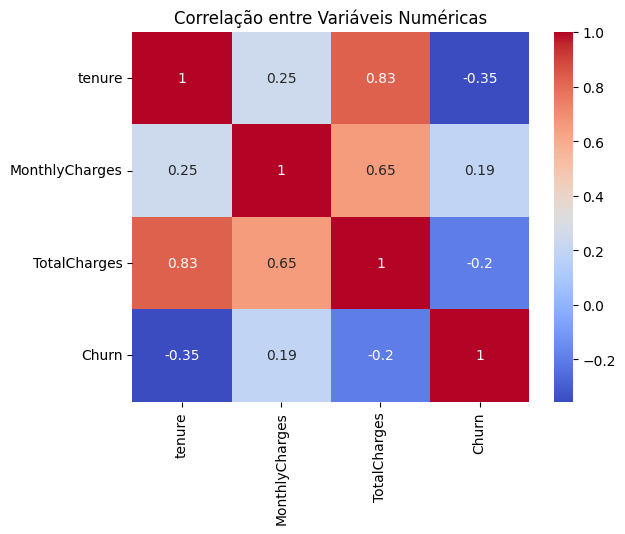

In [9]:
# Correlação entre variáveis numéricas
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre Variáveis Numéricas')
plt.show()

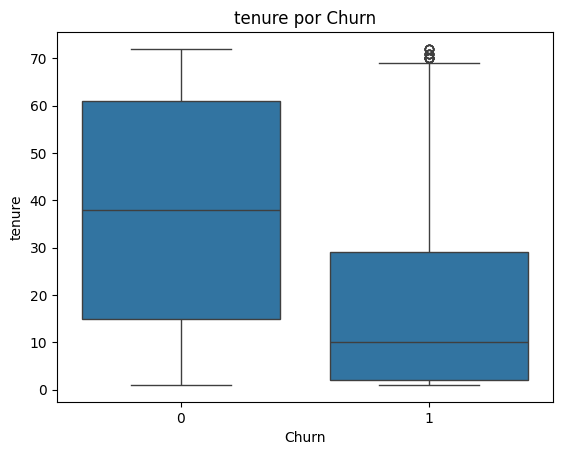

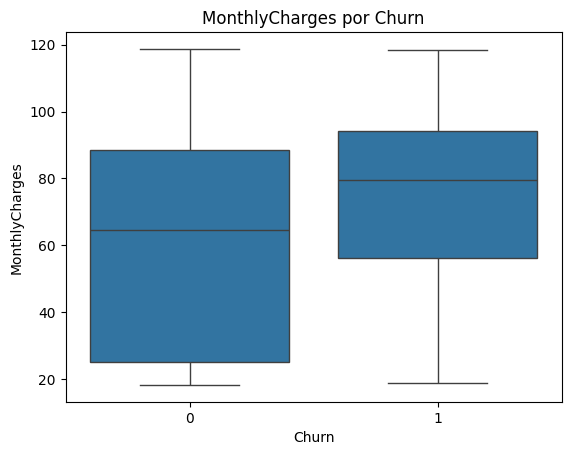

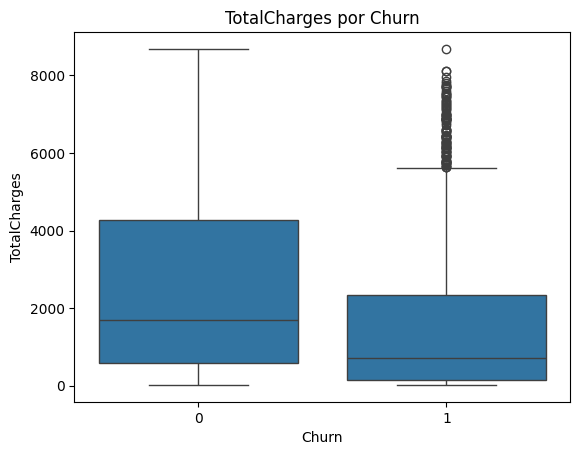

In [10]:
 #Boxplots por churn
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} por Churn')
    plt.show()

In [11]:
# Variáveis categóricas
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('customerID')

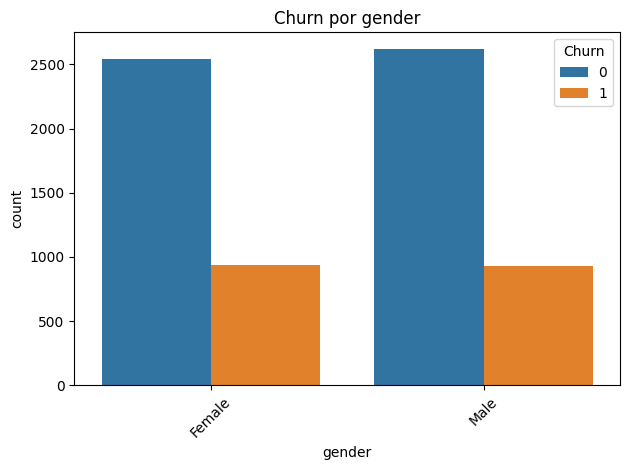

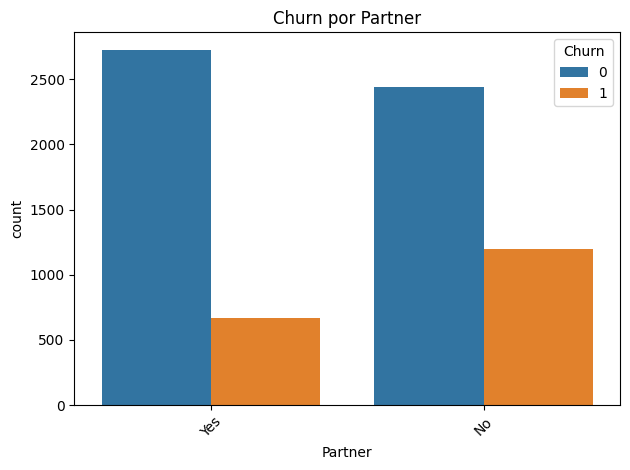

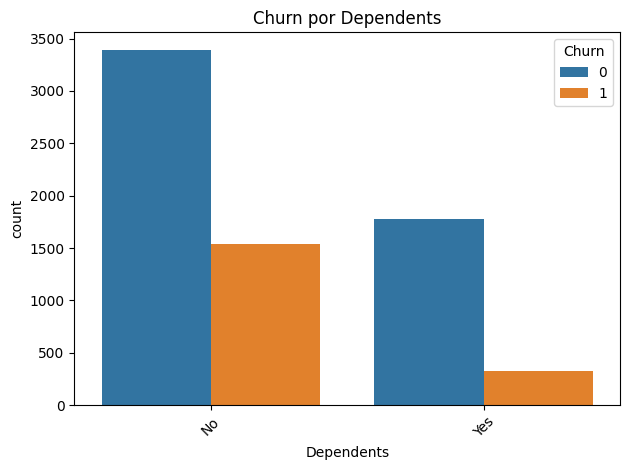

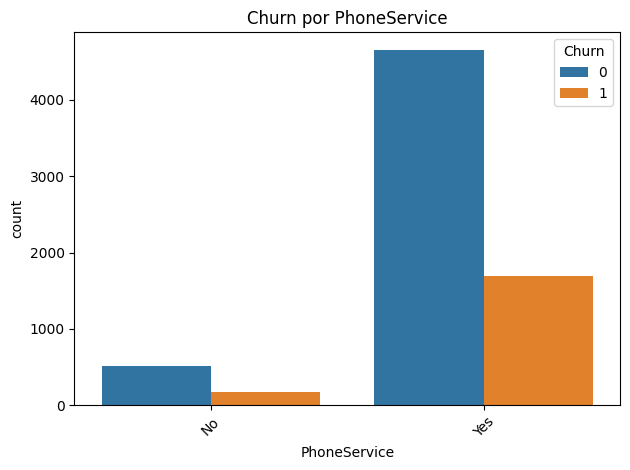

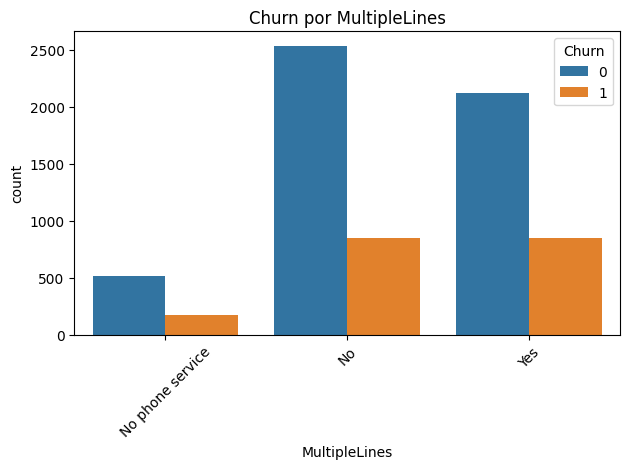

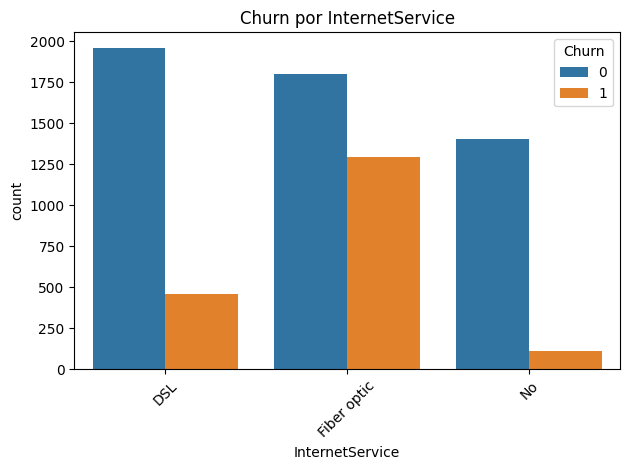

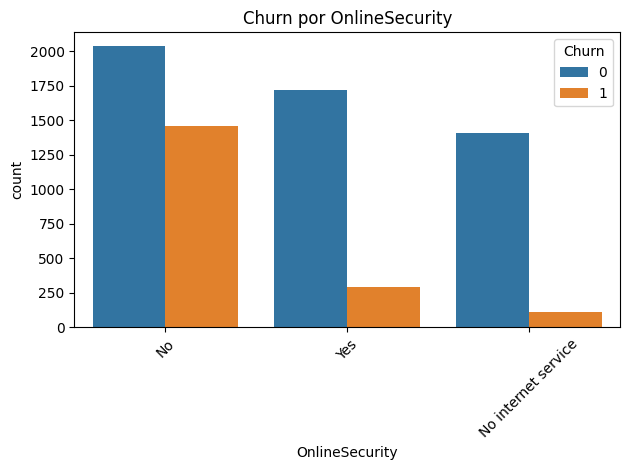

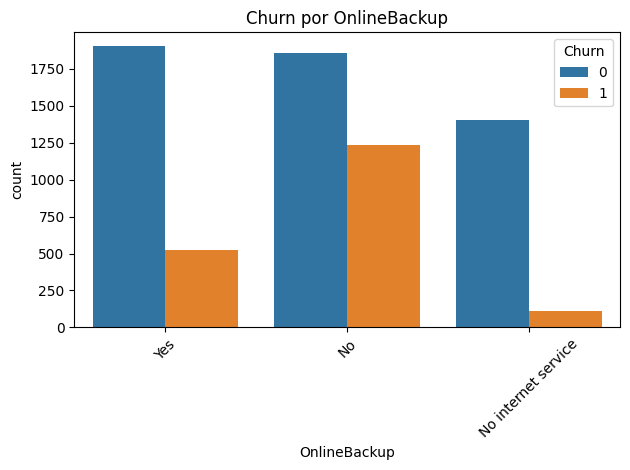

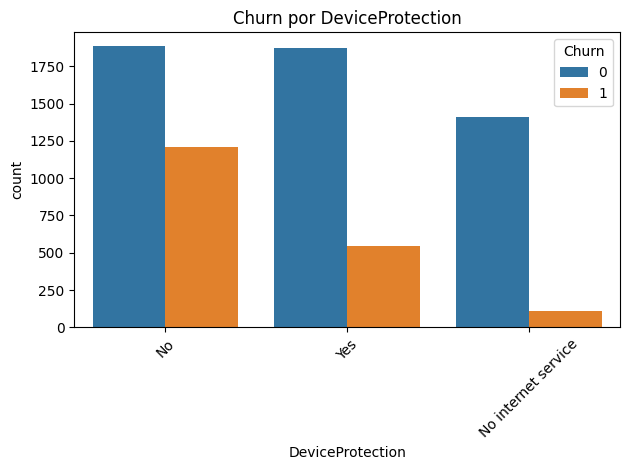

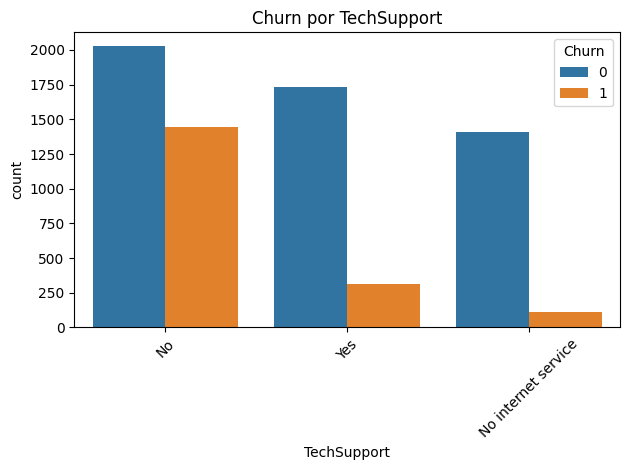

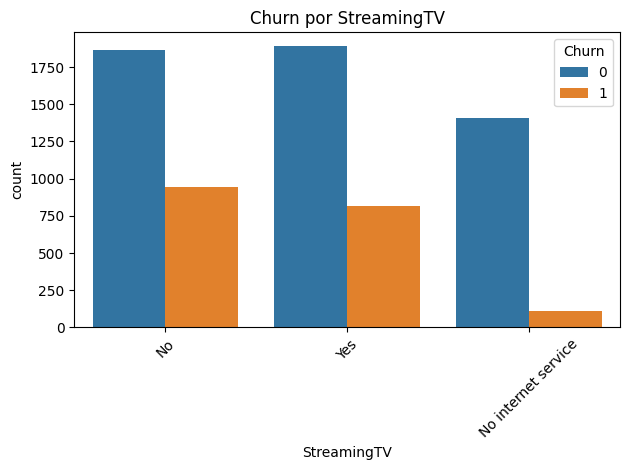

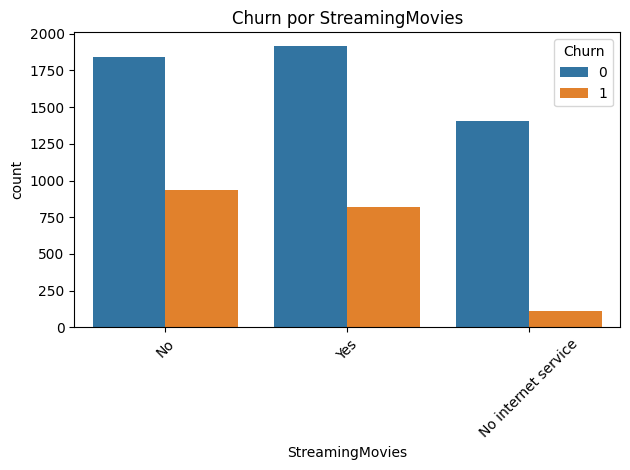

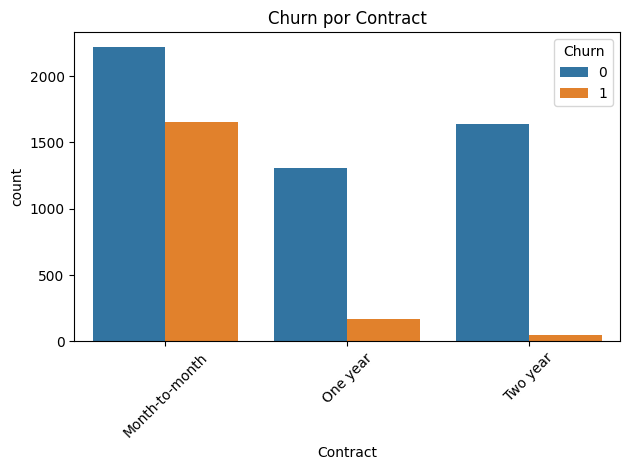

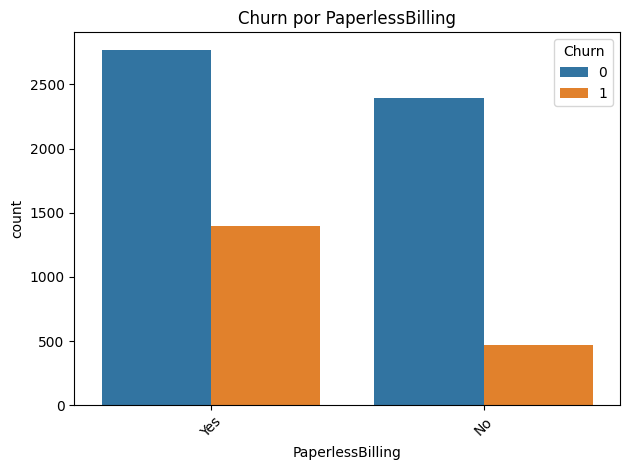

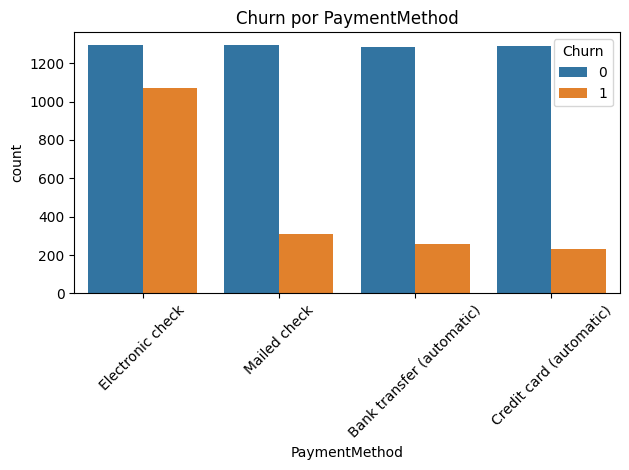

In [12]:
for col in cat_cols:
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f'Churn por {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [13]:
# Churn por tipo de contrato
print(df.groupby('Contract')['Churn'].mean().sort_values(ascending=False))

Contract
Month-to-month    0.427097
One year          0.112772
Two year          0.028487
Name: Churn, dtype: float64


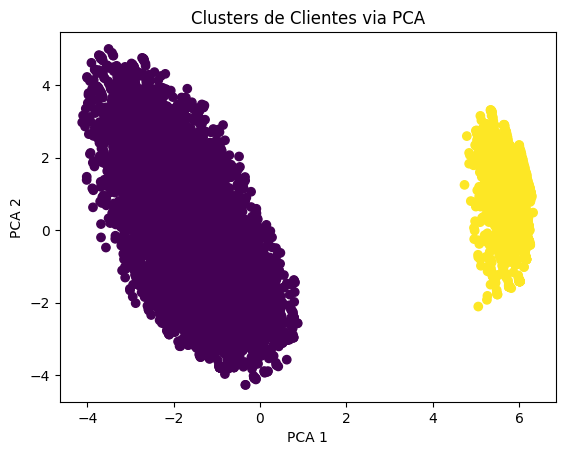

In [14]:
# 4. ANÁLISE DE CLUSTERIZAÇÃO COM PCA
# =============================
df_cluster = df.drop(['customerID'], axis=1)
df_cluster = pd.get_dummies(df_cluster, drop_first=True)

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(pca_result)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('Clusters de Clientes via PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [15]:
# =============================
# 5. MODELAGEM PREDITIVA
# =============================
df_model = pd.get_dummies(df.drop(['customerID'], axis=1), drop_first=True)

X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
# =============================
# 5.1 MODELO: REGRESSÃO LOGÍSTICA
# =============================
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)

print("=== Regressão Logística ===")
print(classification_report(y_test, y_pred_log))
print(f"AUC: {roc_auc_score(y_test, y_pred_log):.4f}")

=== Regressão Logística ===
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.52      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

AUC: 0.7009


In [17]:
# =============================
# 5.2 MODELO: RANDOM FOREST
# =============================
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print(f"AUC: {roc_auc_score(y_test, y_pred_rf):.4f}")

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407

AUC: 0.6862


In [18]:
!pip install imbalanced-learn


In [19]:

from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Distribuição antes do SMOTE:", Counter(y_train))
print("Distribuição após o SMOTE :", Counter(y_train_res))


Distribuição antes do SMOTE: Counter({0: 4130, 1: 1495})
Distribuição após o SMOTE : Counter({1: 4130, 0: 4130})


In [20]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_res, y_train_res)

y_pred_log = log_model.predict(X_test)

print("=== Regressão Logística (com SMOTE) ===")
print(classification_report(y_test, y_pred_log))
print(f"AUC: {roc_auc_score(y_test, y_pred_log):.4f}")


=== Regressão Logística (com SMOTE) ===
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.80      0.73      0.75      1407

AUC: 0.7533


In [21]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_res, y_train_res)

y_pred_rf = rf_model.predict(X_test)

print("=== Random Forest (com SMOTE) ===")
print(classification_report(y_test, y_pred_rf))
print(f"AUC: {roc_auc_score(y_test, y_pred_rf):.4f}")


=== Random Forest (com SMOTE) ===
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1033
           1       0.57      0.58      0.57       374

    accuracy                           0.77      1407
   macro avg       0.71      0.71      0.71      1407
weighted avg       0.77      0.77      0.77      1407

AUC: 0.7089


In [22]:
import joblib

# Salvar os modelos
joblib.dump(log_model, 'modelo_logistico.pkl')
joblib.dump(rf_model, 'modelo_random_forest.pkl')

# Salvar o scaler
joblib.dump(scaler, 'scaler.pkl')

# Salvar as colunas usadas no modelo
joblib.dump(X.columns.tolist(), 'colunas_modelo.pkl')

print("✅ Modelos e scaler salvos com sucesso!")

✅ Modelos e scaler salvos com sucesso!
